In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import kagglehub

path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

100%|██████████| 736M/736M [00:08<00:00, 95.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [ ]:
data_dir='/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    filpath=os.path.join(data_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series,l_series],axis=1)

In [ ]:
df

,filepath,labels
0,/root/.cache/kagglehub/datasets/gunavenkatdodd...,cataract
1,/root/.cache/kagglehub/datasets/gunavenkatdodd...,cataract
2,/root/.cache/kagglehub/datasets/gunavenkatdodd...,cataract
3,/root/.cache/kagglehub/datasets/gunavenkatdodd...,cataract
4,/root/.cache/kagglehub/datasets/gunavenkatdodd...,cataract
...,...,...
4212,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
4213,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
4214,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal
4215,/root/.cache/kagglehub/datasets/gunavenkatdodd...,normal


In [ ]:
strat=df['labels']
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [ ]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(3373, 2)
(422, 2)
(422, 2)


In [ ]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['label','count']
fig=px.bar(count_train,x='label',y='count',title='count of train_df',text_auto=True)
fig.show()

In [ ]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['label','count']
fig=px.bar(count_test,x='label',y='count',title='count of test_df',text_auto=True)
fig.show()

In [ ]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['label','count']
fig=px.bar(count_valid,x='label',y='count',title='count of valid_df',text_auto=True)
fig.show()

In [ ]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


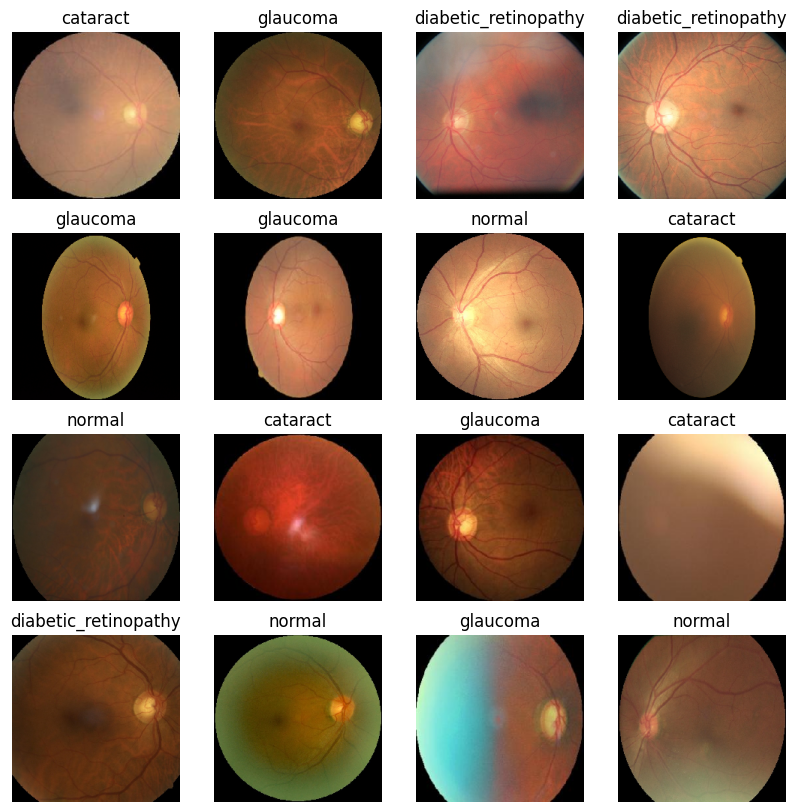

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
base_model=keras.applications.EfficientNetB3(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(4,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,callbacks=[early_stopping])

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7011 - loss: 1.2447 - val_accuracy: 0.7773 - val_loss: 0.6946
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 354ms/step - accuracy: 0.9337 - loss: 0.1708 - val_accuracy: 0.8365 - val_loss: 0.4860
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 334ms/step - accuracy: 0.9616 - loss: 0.1076 - val_accuracy: 0.9028 - val_loss: 0.3222
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 320ms/step - accuracy: 0.9725 - loss: 0.0764 - val_accuracy: 0.9194 - val_loss: 0.3369
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 333ms/step - accuracy: 0.9855 - loss: 0.0423 - val_accuracy: 0.9052 - val_loss: 0.3924
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - accuracy: 0.9855 - loss: 0.0377 - val_accuracy: 0.9123 - val_loss: 0.3583
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 323ms/step - accuracy: 0.9896 - loss: 0.0288 - val_accuracy: 0.9028 - val_loss: 0.4111
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 320ms/step - accuracy: 0.9850 - l

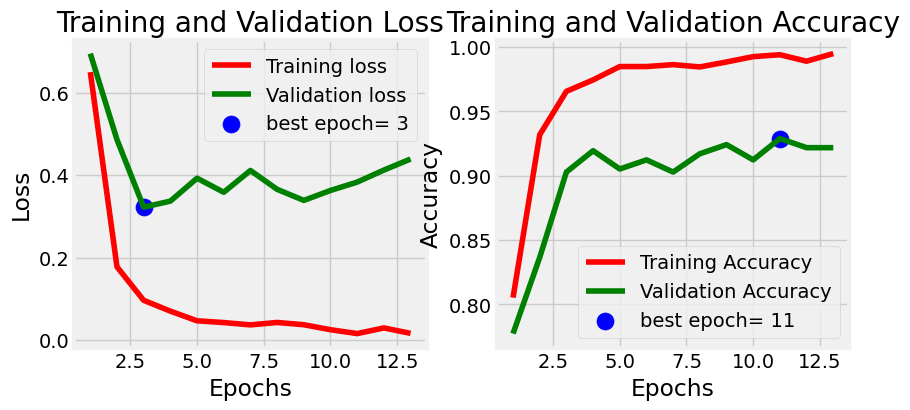

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

211/211 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - accuracy: 0.9826 - loss: 0.0506
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9040 - loss: 0.3201  
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8942 - loss: 0.3336  
Train Loss:  0.04808671772480011
Train Accuracy:  0.9836940169334412
--------------------
Valid Loss:  0.32219699025154114
Valid Accuracy:  0.9028435945510864
--------------------
Test Loss:  0.33706134557724
Test Accuracy:  0.8933649063110352


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step


In [ ]:
y_pred

array([1, 0, 3, 3, 2, 2, 1, 1, 0, 2, 0, 3, 1, 0, 2, 0, 1, 3, 1, 2, 3, 1,
       1, 3, 3, 1, 1, 3, 2, 1, 2, 1, 3, 3, 0, 2, 2, 3, 1, 3, 1, 2, 3, 0,
       3, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 0, 3, 3, 1, 0, 1, 3, 3, 1, 0, 0,
       1, 3, 3, 3, 0, 2, 2, 2, 1, 3, 0, 0, 2, 0, 3, 1, 3, 2, 3, 3, 0, 0,
       3, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 0, 0, 0, 1, 2, 2, 1, 1, 3, 1,
       0, 0, 0, 2, 2, 1, 3, 3, 0, 2, 1, 0, 0, 2, 3, 0, 1, 1, 0, 0, 1, 3,
       2, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 3, 2, 0, 1, 1, 0, 2, 1, 2, 3,
       0, 1, 3, 2, 3, 3, 2, 0, 1, 1, 0, 3, 2, 3, 2, 3, 1, 2, 0, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 3, 3, 0, 0, 3, 2, 3, 1, 0, 0, 0, 2, 1, 3, 1, 0,
       1, 3, 0, 3, 0, 3, 0, 2, 3, 0, 2, 2, 0, 0, 3, 2, 3, 0, 1, 0, 3, 1,
       2, 3, 3, 3, 1, 1, 0, 2, 0, 3, 3, 1, 0, 2, 3, 0, 0, 3, 3, 0, 2, 1,
       1, 3, 0, 1, 2, 0, 1, 0, 3, 3, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 3, 0,
       1, 2, 2, 3, 1, 0, 2, 2, 1, 1, 0, 0, 3, 1, 1, 3, 3, 1, 3, 0, 1, 0,
       2, 0, 2, 0, 0, 1, 1, 0, 3, 2, 3, 0, 3, 1, 0,

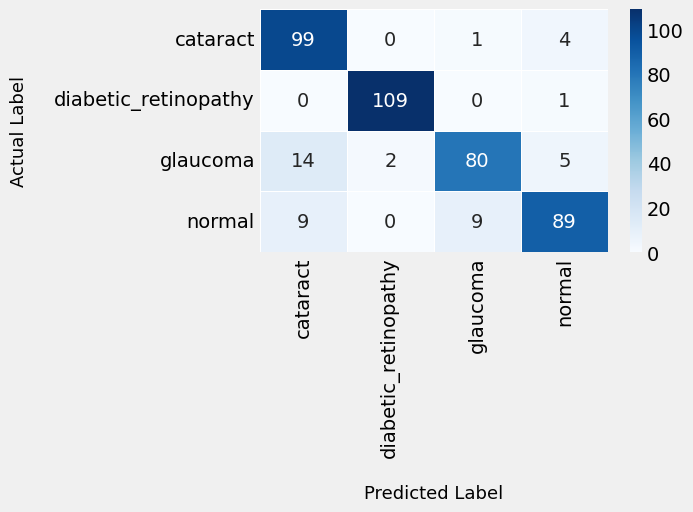

In [ ]:
plt.figure(figsize=(5,3))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

            cataract       0.81      0.95      0.88       104
diabetic_retinopathy       0.98      0.99      0.99       110
            glaucoma       0.89      0.79      0.84       101
              normal       0.90      0.83      0.86       107

            accuracy                           0.89       422
           macro avg       0.90      0.89      0.89       422
        weighted avg       0.90      0.89      0.89       422



In [ ]:
tf.keras.models.save_model(model,'model.hdf5')